In [1]:
import os, sys
import numpy as np
import copy
import cv2 as cv
import pytesseract as pyt
import time

### Set up path variables
___

In [2]:
# set up directories and paths
PARENT_DIR = os.path.dirname(os.path.abspath('__file__'))
ROOT_DIR = os.path.dirname(os.path.abspath(PARENT_DIR))
UTIL_DIR = os.path.join(ROOT_DIR,'util')
CVUTIL_PATH = os.path.join(UTIL_DIR, 'cvutil.py')

# sample frame
FRAME_DIR = os.path.join(PARENT_DIR, 'frame')
SAMPLE_DIR = os.path.join(FRAME_DIR, 'sample_frames')
# frame_path = os.path.join(FRAME_DIR, 'Case_2041_00208_Polcam.bmp')
frame_path = os.path.join(SAMPLE_DIR, '000.bmp')

### Import CVUTIL
___

In [3]:
sys.path.insert(0, UTIL_DIR)
from cvutil import *

### Load sample frame
___

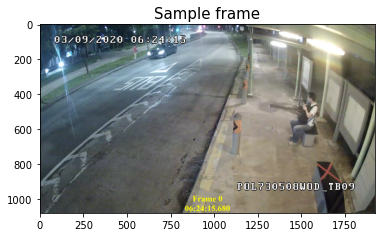

In [4]:
img = read_img(frame_path)
view_img(img, title="Sample frame")

### Convert to grayscale
___

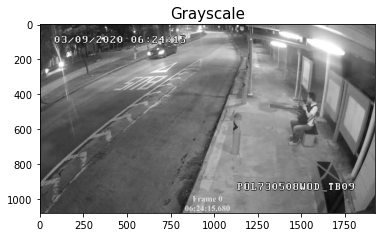

In [5]:
img_gray = convert_to_gray(img, reshape=False)
view_img(img_gray, title="Grayscale")

### Crop timestamp
___

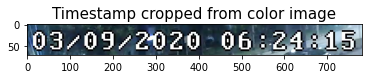

In [33]:
img_color_crop = crop(img, (70,50), (850,120))
view_img(img_color_crop, title="Timestamp cropped from color image")

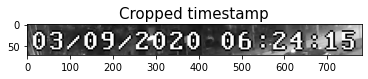

In [6]:
img_crop = crop(img_gray, (70,50), (850,120))
view_img(img_crop, title="Cropped timestamp")

### Color thresholding
___

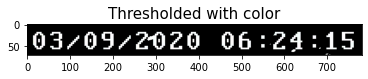

In [39]:
img_color_thresholding = color_thresholding(img_color_crop, (240,240,240), (255,255,255))
view_img(img_color_thresholding, title="Thresholded with color")

### Binarize timestamp
___

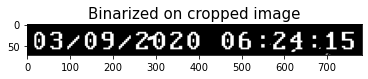

In [7]:
img_bin = thresholding(img_crop, 250, 255)
view_img(img_bin, title="Binarized on cropped image")

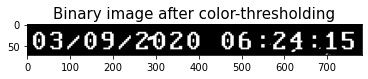

In [40]:
img_color_thres_bin = thresholding(convert_to_gray(img_color_thresholding, reshape=False),
                                  240, 255)
view_img(img_color_thres_bin, title="Binary image after color-thresholding")

### Get edge
___

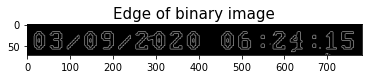

In [8]:
img_edge = getCanny(img_bin, min_val=80, max_val=150)
view_img(img_edge, title="Edge of binary image")

### Initialize kernels
___

In [9]:
kernel_3 = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
kernel_5 = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
kernel_7 = cv.getStructuringElement(cv.MORPH_RECT, (7,7))

### Open, close, erode and dilate binary image with kernel size 3
___

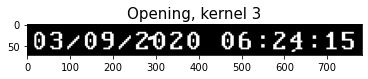

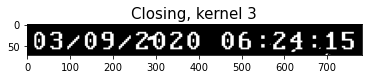

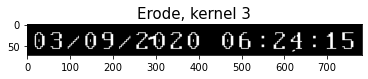

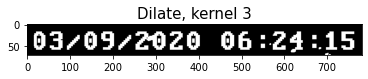

In [10]:
img_open = opening(img_bin, kernel_3)
view_img(img_open, title="Opening, kernel 3")

img_close = closing(img_bin, kernel_3)
view_img(img_close, title="Closing, kernel 3")

img_erode = erode(img_bin, kernel_3)
view_img(img_erode, title="Erode, kernel 3")

img_dilate = dilate(img_bin, kernel_3)
view_img(img_dilate, title="Dilate, kernel 3")

### Open, close, erode and dilate edge image 
___

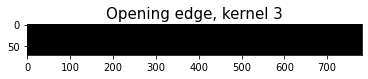

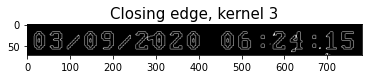

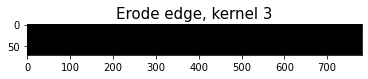

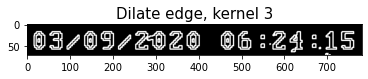

In [11]:
img_edge_open = opening(img_edge, kernel_3)
view_img(img_edge_open, title="Opening edge, kernel 3")

img_edge_close = closing(img_edge, kernel_3)
view_img(img_edge_close, title="Closing edge, kernel 3")

img_edge_erode = erode(img_edge, kernel_3)
view_img(img_edge_erode, title="Erode edge, kernel 3")

img_edge_dilate = dilate(img_edge, kernel_3)
view_img(img_edge_dilate, title="Dilate edge, kernel 3")

### Find contours
___

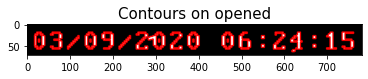

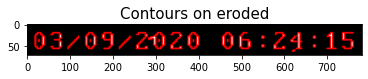

In [12]:
open_contours = findContours(img_open)
open_with_contours = drawContours(img_open, open_contours)
view_img(open_with_contours, title="Contours on opened")

erode_contours = findContours(img_erode)
erode_with_contours = drawContours(img_erode, erode_contours)
view_img(erode_with_contours, title="Contours on eroded")

### Split time into hr, min, sec
___

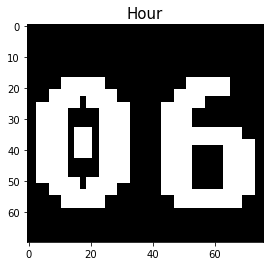

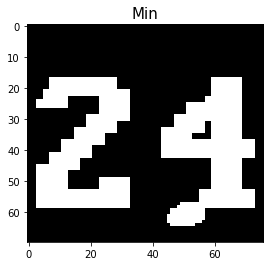

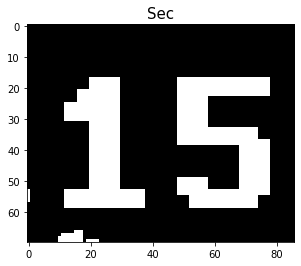

In [13]:
hr = crop(img_dilate, (450,69), (525, 0))
mins = crop(img_dilate, (570, 69), (645, 0))
secs = crop(img_dilate, (685, 69), (770, 0))
view_img(hr, title="Hour")
view_img(mins, title="Min")
view_img(secs, title="Sec")

### OCR entire timestamp
___

In [14]:
custom_config = r'--oem 3 --psm 13'
open_output = pyt.image_to_string(img_open, config=custom_config)
close_output = pyt.image_to_string(img_close, config=custom_config)
erode_output = pyt.image_to_string(img_erode, config=custom_config)
dilate_output = pyt.image_to_string(img_dilate, config=custom_config)

# open_contour_output = pyt.image_to_string(open_with_contours, config=custom_config)
# erode_contour_output = pyt.image_to_string(erode_with_contours, config=custom_config)

In [15]:
mode_list = ['open', 'close', 'erode', 'dilate']
mode_output = [open_output, close_output, erode_output, dilate_output]
for mode, output in zip(mode_list, mode_output):
    print(f"Mode: {mode}, Output: {output}")

Mode: open, Output: 03-09-2020 06:24:15


Mode: close, Output: 03-09-2020 O6:24 115


Mode: erode, Output: 03/09/2020 O6 :24 115


Mode: dilate, Output: O6:24 115




### OCR hr, min, and sec separately
___

In [16]:
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'
hr_output = pyt.image_to_string(hr, config=custom_config)
min_output = pyt.image_to_string(mins, config=custom_config)
sec_output = pyt.image_to_string(secs, config=custom_config)

print("Hr output: ", hr_output)
print("Min output: ", min_output)
print("Sec output: ", sec_output)

Hr output:  06


Min output:  24


Sec output:  15




### Operations in sequence
___

In [51]:
def polcam_operations_4(img_path):
    # set configurations here
    kernel_3 = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    custom_config = r'--oem 3 --psm 13'
    
    x = read_img(img_path)
    x = crop(x, (70,50), (850,120))
    x = color_thresholding(x, (240,240,240), (255,255,255))
    x = thresholding(convert_to_gray(x, reshape=False), 240, 255)
    x = dilate(x, kernel_3)
    
    x_hr = crop(x, (450,69), (525, 0))
    x_mins = crop(x, (570, 69), (645, 0))
    x_secs = crop(x, (685, 64), (770, 5))
    
    hr = pyt.image_to_string(x_hr, config=custom_config)
    mins = pyt.image_to_string(x_mins, config=custom_config)
    secs = pyt.image_to_string(x_secs, config=custom_config)
    
    return hr, mins, secs 

In [49]:
def polcam_operations_3(img_path):
    # set configurations here
#     kernel_3 = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    custom_config = r'--oem 3 --psm 13'
    
    x = read_img(img_path)
    x = crop(x, (70,50), (850,120))
    x = color_thresholding(x, (240,240,240), (255,255,255))
    x = thresholding(convert_to_gray(x, reshape=False), 240, 255)
#     x = dilate(x, kernel_3)
    
    output_string = pyt.image_to_string(x, config=custom_config)
    return output_string

In [46]:
def polcam_operations_2(img_path):
    # set configurations here
    kernel_3 = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    custom_config = r'--oem 3 --psm 13'
    
    x = read_img(img_path)
    x = convert_to_gray(x)
    x = crop(x, (70,50), (850,120))
    x = thresholding(x, 249, 255)
    x = dilate(x, kernel_3)
    
    x_hr = crop(x, (450,69), (525, 0))
    x_mins = crop(x, (570, 69), (645, 0))
    x_secs = crop(x, (685, 64), (770, 5))
    
    hr = pyt.image_to_string(x_hr, config=custom_config)
    mins = pyt.image_to_string(x_mins, config=custom_config)
    secs = pyt.image_to_string(x_secs, config=custom_config)
    
    return hr, mins, secs    

In [47]:
def polcam_operations_1(img_path):
    # set configurations here
    kernel_3 = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    custom_config = r'--oem 3 --psm 13'
    
    x = read_img(img_path)
    x = convert_to_gray(x)
    x = crop(x, (70, 50), (850, 120))
    x = thresholding(x, 249, 255)
    x = opening(x, kernel_3)
    
    output_string = pyt.image_to_string(x, config=custom_config)
    return output_string

### Rundown with operation 1
___

In [28]:
start_time = time.time()
for f in os.listdir(SAMPLE_DIR):
    if f.endswith(".bmp"):
        img_path = os.path.join(SAMPLE_DIR,f)
        output = polcam_operations_1(img_path)
        print("################################")
        print("Frame path: ", img_path)
        print("Timestamp: ", output)
end_time = time.time()
print(f"Time elapsed: {(end_time-start_time):.3f}")

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\000.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\002.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\003.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\004.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\005.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\006.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\054.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\055.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\056.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\057.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\058.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\059.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\107.bmp
Timestamp:  03-09-2020 06:24:23


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\108.bmp
Timestamp:  03-09-2020 06:24:23


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\109.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\110.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\111.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\112.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\160.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\161.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\162.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\163.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\164.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\165.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\213.bmp
Timestamp:  03-09-2020 06:24:32


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\214.bmp
Timestamp:  03-09-2020 06:24:32


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\215.bmp
Timestamp:  03-09-2020 06:24:32


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\216.bmp
Timestamp:  03-09-2020 06:24:33


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\217.bmp
Timestamp:  03-09-2020 06:24:33


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\218.bmp
Timestamp:  03-09-2020 06:24:33


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\266.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\267.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\268.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\269.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\270.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\271.bmp
Timestamp:  #$3-/09-2020 06:24:37


################################
Frame path:  C:\Users\K

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\319.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\320.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\321.bmp
Timestamp:  03-09-2020 O6 :124:541


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\322.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\323.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\324.bmp
Timestamp:  03-09-2020 06:24:42


################################
Frame path:  C:\Users\

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\372.bmp
Timestamp:  03-09-2020 06:24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\373.bmp
Timestamp:  03-09-2020 O6 :24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\374.bmp
Timestamp:  03-09-2020 O6 :24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\375.bmp
Timestamp:  03-09-2020 06:24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\376.bmp
Timestamp:  03-09-2020 06:24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\377.bmp
Timestamp:  03-09-2020 06:24:46


################################
Frame path:  C:\Users\K

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\425.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\426.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\427.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\428.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\429.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\430.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\478.bmp
Timestamp:  03-09-2020 06:24:54


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\479.bmp
Timestamp:  03-09-2020 06:24:54


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\480.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\481.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\482.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\483.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\531.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\532.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\533.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\534.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\535.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\536.bmp
Timestamp:  03-09-2020 O6


################################
Frame path:  C:\Users\KC_Cheng\

### Rundown with operation 2
___

In [29]:
start_time = time.time()
i = 0
for f in os.listdir(SAMPLE_DIR):
    if f.endswith(".bmp"):
        img_path = os.path.join(SAMPLE_DIR, f)
        hr_out, min_out, sec_out = polcam_operations_2(img_path)
        print(f"Frame: {f}, hr: {hr_out}, min: {min_out}, sec: {sec_out}")
        i += 1
end_time = time.time()
print(f"Processing time: {(end_time - start_time):.3f} s.")

Frame: 0, hr: 06

, min: 24

, sec: 15


Frame: 1, hr: 06

, min: 24

, sec: 15


Frame: 2, hr: 06

, min: 24

, sec: 15


Frame: 3, hr: 06

, min: 24

, sec: 15


Frame: 4, hr: 06

, min: 24

, sec: 15


Frame: 5, hr: 06

, min: 24

, sec: 15


Frame: 6, hr: 06

, min: 24

, sec: 15


Frame: 7, hr: 06

, min: 24

, sec: 15


Frame: 8, hr: 06

, min: 24

, sec: 15


Frame: 9, hr: 06

, min: 24

, sec: 15


Frame: 10, hr: 06

, min: 24

, sec: 15


Frame: 11, hr: 06

, min: 24

, sec: 16


Frame: 12, hr: 06

, min: 24

, sec: 16


Frame: 13, hr: 06

, min: 24

, sec: 16


Frame: 14, hr: 06

, min: 24

, sec: 16


Frame: 15, hr: 06

, min: 24

, sec: 16


Frame: 16, hr: 06

, min: 24

, sec: 16


Frame: 17, hr: 06

, min: 24

, sec: 16


Frame: 18, hr: 06

, min: 24

, sec: 16


Frame: 19, hr: 06

, min: 24

, sec: 16


Frame: 20, hr: 06

, min: 24

, sec: 16


Frame: 21, hr: 06

, min: 24

, sec: 16


Frame: 22, hr: 06

, min: 24

, sec: 16


Frame: 23, hr: 06

, min: 24

, sec: 17


Fr

Frame: 194, hr: 06

, min: 24

, sec: 31


Frame: 195, hr: 06

, min: 24

, sec: 31


Frame: 196, hr: 06

, min: 24

, sec: 31


Frame: 197, hr: 06

, min: 24

, sec: 31


Frame: 198, hr: 06

, min: 24

, sec: 31


Frame: 199, hr: 06

, min: 24

, sec: 31


Frame: 200, hr: 06

, min: 24

, sec: 31


Frame: 201, hr: 06

, min: 24

, sec: 31


Frame: 202, hr: 06

, min: 24

, sec: 31


Frame: 203, hr: 06

, min: 24

, sec: 32


Frame: 204, hr: 06

, min: 24

, sec: 32


Frame: 205, hr: 06

, min: 24

, sec: 32


Frame: 206, hr: 06

, min: 24

, sec: 32


Frame: 207, hr: 06

, min: 24

, sec: 32


Frame: 208, hr: 06

, min: 24

, sec: 32


Frame: 209, hr: 06

, min: 24

, sec: 32


Frame: 210, hr: 06

, min: 24

, sec: 32


Frame: 211, hr: 06

, min: 24

, sec: 32


Frame: 212, hr: 06

, min: 24

, sec: 32


Frame: 213, hr: 06

, min: 24

, sec: 32


Frame: 214, hr: 06

, min: 24

, sec: 32


Frame: 215, hr: 06

, min: 24

, sec: 33


Frame: 216, hr: 06

, min: 24

, sec: 33


Frame: 217,

Frame: 384, hr: 06

, min: 24

, sec: 47


Frame: 385, hr: 06

, min: 24

, sec: 47


Frame: 386, hr: 06

, min: 24

, sec: 47


Frame: 387, hr: 06

, min: 24

, sec: 47


Frame: 388, hr: 06

, min: 24

, sec: 47


Frame: 389, hr: 06

, min: 24

, sec: 47


Frame: 390, hr: 06

, min: 24

, sec: 47


Frame: 391, hr: 06

, min: 24

, sec: 47


Frame: 392, hr: 06

, min: 24

, sec: 47


Frame: 393, hr: 06

, min: 24

, sec: 47


Frame: 394, hr: 06

, min: 24

, sec: 47


Frame: 395, hr: 06

, min: 24

, sec: 48


Frame: 396, hr: 06

, min: 24

, sec: 48


Frame: 397, hr: 06

, min: 24

, sec: 48


Frame: 398, hr: 06

, min: 24

, sec: 48


Frame: 399, hr: 06

, min: 24

, sec: 48


Frame: 400, hr: 06

, min: 24

, sec: 48


Frame: 401, hr: 06

, min: 24

, sec: 48


Frame: 402, hr: 06

, min: 24

, sec: 48


Frame: 403, hr: 06

, min: 24

, sec: 48


Frame: 404, hr: 06

, min: 24

, sec: 48


Frame: 405, hr: 06

, min: 24

, sec: 48


Frame: 406, hr: 06

, min: 24

, sec: 49


Frame: 407,

### Rundown with operation 3
___

In [50]:
start_time = time.time()
for f in os.listdir(SAMPLE_DIR):
    if f.endswith(".bmp"):
        img_path = os.path.join(SAMPLE_DIR,f)
        output = polcam_operations_3(img_path)
        print("################################")
        print("Frame path: ", img_path)
        print("Timestamp: ", output)
end_time = time.time()
print(f"Time elapsed: {(end_time-start_time):.3f}")

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\000.bmp
Timestamp:  03-09-2020 O6:24 115


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\002.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\003.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\004.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\005.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\006.bmp
Timestamp:  03-09-2020 06:24:15


################################
Frame path:  C:\Users\KC

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\054.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\055.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\056.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\057.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\058.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\059.bmp
Timestamp:  03-09-2020 06:24:19


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\107.bmp
Timestamp:  03-09-2020 06:24:23


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\108.bmp
Timestamp:  03-09-2020 06:24:23


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\109.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\110.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\111.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\112.bmp
Timestamp:  03-09-2020 06:24:24


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\160.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\161.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\162.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\163.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\164.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\165.bmp
Timestamp:  03-09-2020 06:24:28


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\213.bmp
Timestamp:  03-09-2020 06:24:32


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\214.bmp
Timestamp:  03-09-2020 06:24:32


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\215.bmp
Timestamp:  03-09-2020 06:24:32


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\216.bmp
Timestamp:  03-09-2020 06:24:33


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\217.bmp
Timestamp:  03-09-2020 06:24:33


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\218.bmp
Timestamp:  03-09-2020 06:24:33


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\266.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\267.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\268.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\269.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\270.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\271.bmp
Timestamp:  03-09-2020 06:24:37


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\319.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\320.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\321.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\322.bmp
Timestamp:  03-09-2020 O6


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\323.bmp
Timestamp:  03-09-2020 06:24:41


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\324.bmp
Timestamp:  03-09-2020 06:24:42


################################
Frame path:  C:\Users\KC_Cheng\

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\372.bmp
Timestamp:  03-09-2020 06:24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\373.bmp
Timestamp:  03-09-2020 O6 :24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\374.bmp
Timestamp:  03-09-2020 O6 :24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\375.bmp
Timestamp:  03-09-2020 O6 :24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\376.bmp
Timestamp:  03-09-2020 06:24:46


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\377.bmp
Timestamp:  03-09-2020 06:24:46


################################
Frame path:  C:\Users\

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\425.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\426.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\427.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\428.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\429.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\430.bmp
Timestamp:  03-09-2020 06:24:50


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\478.bmp
Timestamp:  03-09-2020 06:24:54


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\479.bmp
Timestamp:  03-09-2020 06:24:54


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\480.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\481.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\482.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\483.bmp
Timestamp:  03-09-2020 06:24:55


################################
Frame path:  C:\Users\KC_

################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\531.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\532.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\533.bmp
Timestamp:  03-09-2020 O6


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\534.bmp
Timestamp:  03-09-2020 O6


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\535.bmp
Timestamp:  03-09-2020 06:24:59


################################
Frame path:  C:\Users\KC_Cheng\Documents\hsa_ocr\ocr_protocol\frame\sample_frames\536.bmp
Timestamp:  03-09-2020 O6


################################
Frame path:  C:\Users\KC_Cheng\Documents\hs

### Rundown with operation 4
___

In [52]:
start_time = time.time()
i = 0
for f in os.listdir(SAMPLE_DIR):
    if f.endswith(".bmp"):
        img_path = os.path.join(SAMPLE_DIR, f)
        hr_out, min_out, sec_out = polcam_operations_4(img_path)
        print(f"Frame: {f}, hr: {hr_out}, min: {min_out}, sec: {sec_out}")
        i += 1
end_time = time.time()
print(f"Processing time: {(end_time - start_time):.3f} s.")

Frame: 0, hr: 06

, min: 24

, sec: 15


Frame: 1, hr: 06

, min: 24

, sec: 15


Frame: 2, hr: 06

, min: 24

, sec: 15


Frame: 3, hr: 06

, min: 24

, sec: 15


Frame: 4, hr: 06

, min: 24

, sec: 15


Frame: 5, hr: 06

, min: 24

, sec: 15


Frame: 6, hr: 06

, min: 24

, sec: 15


Frame: 7, hr: 06

, min: 24

, sec: 15


Frame: 8, hr: 06

, min: 24

, sec: 15


Frame: 9, hr: 06

, min: 24

, sec: 15


Frame: 10, hr: 06

, min: 24

, sec: 15


Frame: 11, hr: 06

, min: 24

, sec: 16


Frame: 12, hr: 06

, min: 24

, sec: 16


Frame: 13, hr: 06

, min: 24

, sec: 16


Frame: 14, hr: 06

, min: 24

, sec: 16


Frame: 15, hr: 06

, min: 24

, sec: 16


Frame: 16, hr: 06

, min: 24

, sec: 16


Frame: 17, hr: 06

, min: 24

, sec: 16


Frame: 18, hr: 06

, min: 24

, sec: 16


Frame: 19, hr: 06

, min: 24

, sec: 16


Frame: 20, hr: 06

, min: 24

, sec: 16


Frame: 21, hr: 06

, min: 24

, sec: 16


Frame: 22, hr: 06

, min: 24

, sec: 16


Frame: 23, hr: 06

, min: 24

, sec: 17


Fr

Frame: 194, hr: 06

, min: 24

, sec: 31


Frame: 195, hr: 06

, min: 24

, sec: 31


Frame: 196, hr: 06

, min: 24

, sec: 31


Frame: 197, hr: 06

, min: 24

, sec: 31


Frame: 198, hr: 06

, min: 24

, sec: 31


Frame: 199, hr: 06

, min: 24

, sec: 31


Frame: 200, hr: 06

, min: 24

, sec: 31


Frame: 201, hr: 06

, min: 24

, sec: 31


Frame: 202, hr: 06

, min: 24

, sec: 31


Frame: 203, hr: 06

, min: 24

, sec: 32


Frame: 204, hr: 06

, min: 24

, sec: 32


Frame: 205, hr: 06

, min: 24

, sec: 32


Frame: 206, hr: 06

, min: 24

, sec: 32


Frame: 207, hr: 06

, min: 24

, sec: 32


Frame: 208, hr: 06

, min: 24

, sec: 32


Frame: 209, hr: 06

, min: 24

, sec: 32


Frame: 210, hr: 06

, min: 24

, sec: 32


Frame: 211, hr: 06

, min: 24

, sec: 32


Frame: 212, hr: 06

, min: 24

, sec: 32


Frame: 213, hr: 06

, min: 24

, sec: 32


Frame: 214, hr: 06

, min: 24

, sec: 32


Frame: 215, hr: 06

, min: 24

, sec: 33


Frame: 216, hr: 06

, min: 24

, sec: 33


Frame: 217,

Frame: 384, hr: 06

, min: 24

, sec: 47


Frame: 385, hr: 06

, min: 24

, sec: 47


Frame: 386, hr: 06

, min: 24

, sec: 47


Frame: 387, hr: 06

, min: 24

, sec: 47


Frame: 388, hr: 06

, min: 24

, sec: 47


Frame: 389, hr: 06

, min: 24

, sec: 47


Frame: 390, hr: 06

, min: 24

, sec: 47


Frame: 391, hr: 06

, min: 24

, sec: 47


Frame: 392, hr: 06

, min: 24

, sec: 47


Frame: 393, hr: 06

, min: 24

, sec: 47


Frame: 394, hr: 06

, min: 24

, sec: 47


Frame: 395, hr: 06

, min: 24

, sec: 48


Frame: 396, hr: 06

, min: 24

, sec: 48


Frame: 397, hr: 06

, min: 24

, sec: 48


Frame: 398, hr: 06

, min: 24

, sec: 48


Frame: 399, hr: 06

, min: 24

, sec: 48


Frame: 400, hr: 06

, min: 24

, sec: 48


Frame: 401, hr: 06

, min: 24

, sec: 48


Frame: 402, hr: 06

, min: 24

, sec: 48


Frame: 403, hr: 06

, min: 24

, sec: 48


Frame: 404, hr: 06

, min: 24

, sec: 48


Frame: 405, hr: 06

, min: 24

, sec: 48


Frame: 406, hr: 06

, min: 24

, sec: 49


Frame: 407,